# Lab 05 -Time Series Modeling

## Overview

The purpose of this tutorial is to establish a foundation for time series analysis on remotely sensed data. You will be introduced to the fundamentals of time series modeling, including decomposition, autocorrelation and modeling historical changes. At the completion of this tutorial, you will be able to build an explanatory model for temporal data which can be used in many different avenues of research.

## Background

One of the paradigm-changing features of Earth Engine is the ability to access decades of imagery without the previous limitation of needing to download, organize, store and process this information. For instance, within the Landsat image collection we can access imagery back to 1972, allowing us to look at an area to visualize and quantify how much it's changed over time. With Earth Engine, Google maintains the data and offers it's computing power for processing - users can access tens or hundreds of time-sequenced images and quantify change across decades.

To explain the concepts of time series modeling, let's begin with a dataset that illustrates what we are trying to do. The line chart below references electricity production over thirty years, with one distinct data point per month. What can we observe?

1. Production tends to increase each year - In this case, it appears to level out after 2010, but there is a general trend upwards. 

2. Within each yearly cycle, we see that there is a sharp peak in June and July, and a trough in October and December. An annual, 12-month cycle is specifically referred to as 'seasonality', although there can be other cyclical time periods (ex., a housing market in a specific area may see a recurring pattern in house prices that occurs roughly every 7 years)
3. Finally, the magnitude of the difference between each yearly peak and trough increases over time as well. 

![Time Series Example](./im/im_05_01.png)

1. With these observations, we can address each of the components individually and perhaps build an explanatory model. The time series decomposition below (generated in R) breaks up the data into separate components.
   1. The 'observed' line chart is the data in original form.
   2. The next chart is a trendline built using a window function (each data point is plotted as the average of the previous 12 data points). You can see the general trend of the data and determine whether a linear fit is appropriate.
   3. The seasonal chart seeks to identify cyclical patterns in the data (in this case, patterns that repeat every 12 months). It subtracts the trend from the observed points and averages the data for each time period (month).
   4. Finally, the 'random' line chart is the residual amount remaining when you remove the trend and seasonality from the data.

![Time Series Decomposition](./im/im_05_02.png)

### Limitations in Remote Sensing Time Series

Time series modeling aims to build an explanatory model of the data without overfitting the problem set—to use as simple a model as possible while accounting for as much of the data as possible. The previous example was used to illustrate the concepts of breaking down time series data into component parts, but remote sensing data has additional limitations that make this more challenging. Note that in the previous example there was a well-formed data point for every single month—nothing was missing or obviously erroneous. It is almost inevitable that you will not get this same level of precision from remote sensing data. [Landsat-8](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2) has 16-day temporal resolution, but depending on the area, removing cloudy pixels will remove a significant portion. In a test area in the Galapagos Islands, over 85% of the data was removed due to cloud masking or atmospheric conditions. Issues such as the [Landsat 7 Scan Line Corrector malfunction](https://www.usgs.gov/faqs/what-landsat-7-etm-slc-data) might prevent a cohesive time series dataset depending on your time period of research. Also, while the time series example we used involved measured values on the same scale throughout the time series (e.g., a gigawatt is the same unit of measurement throughout the entire time series), with remote sensing we often run into situations where the magnitude of measurement changes. If we are researching winter crop yield and an image is collected right after a heavy snowfall, how do we compare this value? Do we keep this data or remove it? Additionally, atmospheric conditions can skew the visual results, where the hue of the vegetation changes drastically from image to image due to atmospheric conditions (fog, ground moisture, cloud cover).

It is important to understand the characteristics of both your data and what you are trying to measure. Building a time series model to understand cyclical changes in vegetation can provide useful information in understanding crop yield, but if you do not account for issues in the data, you can end up building a time series model with erroneous results. Many time series modeling tools, such as [ARIMA modeling](https://otexts.com/fpp2/arima.html), are not directly applicable in certain settings due to missing data, non-standard collection periods and varying intensity due to atmospheric conditions. In this tutorial, we will focus on understanding linear trends and harmonic modeling.

### Multi-Temporal Data in Earth Engine

Time series data in Earth Engine are represented as a series of images called '[Image Collections](https://developers.google.com/earth-engine/guides/ic_creating)'. As a result of the complicating factors in remote sensing discussed earlier, analyzing time series in Earth Engine is unlike time series modeling in traditional methods. From a programming sense, we will join data together to define temporal relationships between collection items and build functions to reduce this time.

First, some very basic mathematical notation for time series. A time series is an array of the value being measured, sorted chronologically: $\textbf{p}_{t}  = t_{0} + t_{1}... t_{N}$, where each *t* is the given value in the series.

### Data Preparation and Preprocessing

The first step in analysis of time series data is to import data of interest and plot the data around our region of interest, a deciduous forest near Blacksburg, VA, USA.

We begin by loading in the Landsat 8 collection and provide a point at the region of interest. Additionally, we will create a time field.

In [117]:
import ee, geemap
import folium
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from f_build_map import build_map
from f_mask_Landsat8SR_2 import mask_Landsat8SR_2

# Initialize the Earth Engine module.
ee.Initialize()

In [148]:
lat = 37.22; lon = -80.42; 
zoom = 11;
image_collection_name = 'LANDSAT/LC08/C01/T1_8DAY_NDVI'
date_start = '2014-01-01'
date_end = '2020-05-31'
name = 'Landsat 8 NDVI'
point = ee.Geometry.Point([lon, lat])
# 500 meter buffer around our Point Of Interest (POI)
poi = point.buffer(500)

image = (
    ee.ImageCollection(image_collection_name)
         .filterBounds(point)
         .filterDate(date_start, date_end)
         
)

palette = [
    'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301'
  ]

vizParams = {

    'min': 0, 
    'max': 1,
    'palette': palette
}

# Define a map centered on southern Maine.
map = build_map(lat, lon, zoom, vizParams, image, name)
#map.add_ee_layer(image, vizParams)
display(map)

Map(center=[37.22, -80.42], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childr…

In [149]:
def poi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30).get('NDVI')
    return img.set('date', img.date().format()).set('mean',mean)

In [150]:
ndvi = ee.ImageCollection(image_collection_name).filterDate(date_start,date_end)

In [151]:
poi_reduced_imgs = ndvi.map(poi_mean)

In [152]:
nested_list = poi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

In [153]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])
df

,date,mean
0,2014-01-09T00:00:00,0.256862
1,2014-01-25T00:00:00,0.213384
2,2014-02-26T00:00:00,0.210169
3,2014-03-14T00:00:00,0.246643
4,2014-03-30T00:00:00,0.130528
...,...,...
112,2020-03-05T00:00:00,0.042078
113,2020-03-21T00:00:00,0.085598
114,2020-04-06T00:00:00,0.021362
115,2020-04-22T00:00:00,0.374251


In [154]:
df['date'] = pd.to_datetime(df['date'])

df = df.set_index('date')

df

,mean
date,
2014-01-09,0.256862
2014-01-25,0.213384
2014-02-26,0.210169
2014-03-14,0.246643
2014-03-30,0.130528
...,...
2020-03-05,0.042078
2020-03-21,0.085598
2020-04-06,0.021362


In [155]:
map1 = geemap.Map()
map1.centerObject(poi, zoom=13)
map1.add_basemap("SATELLITE")
map1.addLayer(poi, {}, "Virginia Tech")
map1.addLayerControl()
map1

Map(center=[37.22000051295658, -80.41999998215914], controls=(WidgetControl(options=['position', 'transparent_…

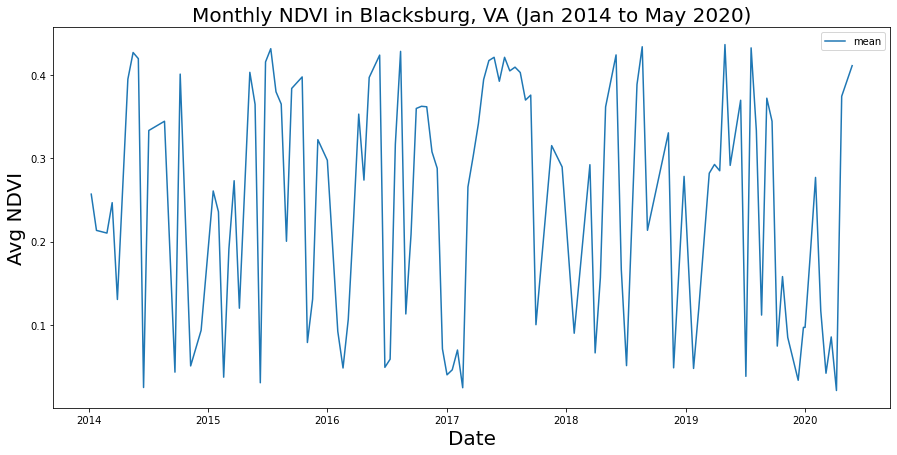

In [156]:
# we create a figure with pyplot and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15,7))

# we'll create the plot by setting our dataframe to the data argument
sns.lineplot(data=df, ax=ax)

# we'll set the labels and title
ax.set_ylabel('Avg NDVI',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Monthly NDVI in Blacksburg, VA (Jan 2014 to May 2020)',fontsize=20);

In [157]:
df.idxmax()

mean   2019-05-01
dtype: datetime64[ns]

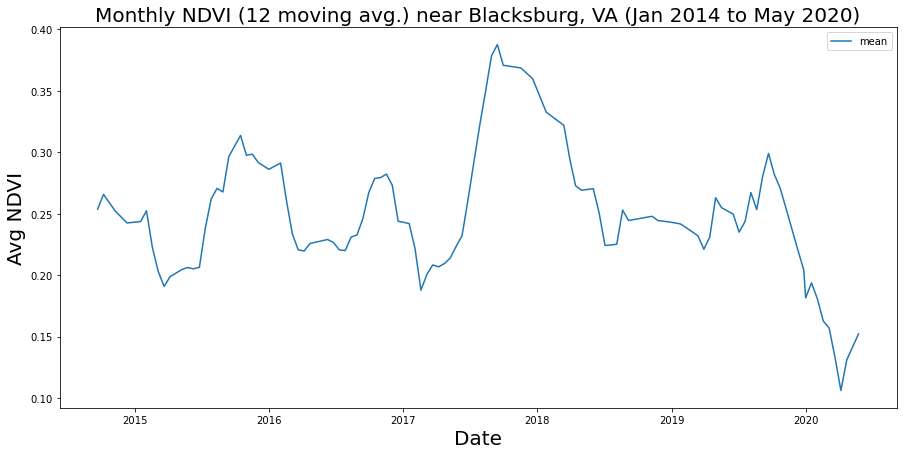

In [158]:
fig, ax = plt.subplots(figsize=(15,7))

# we'll plot the moving average using ".rolling" and set a window of 12 months
window=12
sns.lineplot(data=df.rolling(window).mean(), ax=ax)

# we'll set the labels and title
ax.set_ylabel('Avg NDVI',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title(f'Monthly NDVI ({window} moving avg.) near Blacksburg, VA (Jan 2014 to May 2020)',fontsize=20);

The function `maskL8sr` is a cloud masking function that uses quality bands of Landsat 8 to mask out any pixels that are obscured by cloud and cloud shadow, or are saturated. Note that this function is Landsat 8 specific, using other platforms will require a different setup.

We'll use the Normalized Difference Vegetation Index (NDVI) as our time series signal. It is a well-known metric for measuring vegetation productivity—for this region of interest, we expect there to be strong seasonality, and perhaps a gradual linear trend over time. In the code block below, we create a function called `addVariables` that extracts the date of each image, calculates NDVI and adds it to an array. We can then use `.map()` to apply the two functions we defined to build a time series model of our data.

# Redo all below 

Concepts are above - follow along with traditional TS modeling 

To visualize the data, we will export a chart at the location of interest. We will add a linear trend line for reference. 

In [ ]:
// Plot a time series of NDVI at a single location.
var l8Chart = ui.Chart.image.series(filteredLandsat.select('NDVI'), roi)
  .setChartType('ScatterChart')
  .setOptions({
   title: 'Landsat 8 NDVI Time Series at ROI',
   trendlines: {0: {
				color: 'CC0000'
   }},
   lineWidth: 1,
   pointSize: 3,
  });
print(l8Chart);

You can click on the 'export' button next to the chart to view an interactive chart. Scroll over some of the data points and look at the relationships between the data. A line connecting two dots means that they are sequential data points (notice that there are relatively few sequential points). We can also see that there are relatively large jumps in the data, with an upward climb somewhere between March and late April, and a descent in late August. Each year is slightly different, but we can surmise that this is due to seasonal rains in the spring and leaves dying off in the fall. Finally, the general trend is downward, although the February 2021 datapoint might have significant leverage on the trend.

![Linear Trend](./im/im_05_03.png)

### Linear Modeling of Time

Lots of interesting analyses can be done to time series by harnessing the `linearRegression()` [reducer](https://developers.google.com/earth-engine/api_docs#eereducerlinearregression). To estimate linear trends over time, consider the following linear model, where $\epsilon_t$ is a random error:

$$ y = \beta_0 + \beta_1X_1 + ... + \beta_nX_n + \epsilon_t \tag{1} $$

This is the model behind the trendline added to the chart you just created. We can use this model to detrend our data (explain the upward or downward movement of the data by subtracting observed values from the fitted model values). For now, the goal is to discover the values of the beta coefficients.

To fit this trend model to the Landsat-based NDVI series using Ordinary Least Squares ([OLS](https://setosa.io/ev/ordinary-least-squares-regression/)), use the `linearRegression()` reducer:   

In [1]:
// List of the independent variable names
var independents = ee.List(['constant', 't']);
// Name of the dependent variable.
var dependent = ee.String('NDVI');
// Compute a linear trend. This will have two bands: 'residuals' and 
// a 2x1 band called coefficients (columns are for dependent variables).
var trend = filteredLandsat.select(independents.add(dependent))
		.reduce(ee.Reducer.linearRegression(independents.length(), 1));
Map.addLayer(trend, {}, 'Trend Array Image')
// Flatten the coefficients into a 2-band image
var coefficients = trend.select('coefficients')
    .arrayProject([0])
    .arrayFlatten([independents]);

SyntaxError: invalid syntax (<ipython-input-1-bf348cbbf3c1>, line 1)

The image added to the map is a two-band image in which each pixel contains values for $\beta_0$ and $\beta_1$. Click around the map with the inspector, and look at some of the values. We can see that most pixels around our region of interest have a negative trend—although darker values indicate a shallow negative trend, while bright red pixels indicate a steeper descent.

Use the model to "detrend" the original NDVI time series. By detrend, we mean account for the slope of the chart and remove it from the original data.

In [2]:
// Compute a detrended series.
var detrended = filteredLandsat.map(function(image) {
return image.select(dependent).subtract(
       image.select(independents).multiply(coefficients).reduce('sum'))
       .rename(dependent)
       .copyProperties(image, [timeField]);
       });

SyntaxError: invalid syntax (<ipython-input-2-5048d4f05f91>, line 1)


Plot the detrended results  

var detrendedChart = ui.Chart.image.series(detrended, roi, null, 30)
.setOptions({
  title: 'Detrended Landsat Time Series at ROI',
  lineWidth: 1,
  pointSize: 3,
});
print(detrendedChart);

Compared to our earlier graph, the data looks similar—but now, the slight downward slope is accounted for with our linear model. Each fitted data point (data point on the linear model) is subtracted from each of the observed data points. Additionally, the Y-axis is now centered at 0, and the scale ranges from 0 to +/- 0.45 This allows us to focus on cyclical patterns in the data with long-term trends in the data removed. 

![Detrended Data](./im/im_05_04.png)

## Estimate Seasonality with a Harmonic Model

Consider the following linear model, where $e_t$ is random error, $A$ is amplitude, $\omega$ is frequency, and $\phi$ is phase:

$$
p_t = \beta_0 + \beta_1t + Acos(2\pi\omega t - \phi) + e_t
$$

We can decompose our function into separate cosine and sine elements.  

$$
p_t = \beta_0 + \beta_1t + \beta_2cos(2\pi\omega t) + \beta_3sin(2\pi\omega t) + e_t
$$

Note that $\beta_2 = Acos(\phi)$ and $\beta_3 = Asin(\phi)$, implying $A = (\beta_2^2 + \beta_3^2)^½$ and $\phi = atan(\frac{\beta_3}{\beta_2})$). 

In simpler terms, we are breaking up more complex curves into a set of simplified cosine waves with an additive term. Mark Jakubauskas has an informative [paper](https://www.isprs.org/proceedings/xxxiii/congress/part4/384_xxxiii-part4.pdf) that breaks down the process, and there are many resources that elaborate more on the math behind harmonic models. Building a harmonic model is used in remote sensing applications because of its flexibility in accounting for cyclicality with simple, reproducible shapes. If there is a seasonal trend in the data, the ordered nature of a cosine curve can likely approximate it.

To fit this model to the time series, set $\omega$=1 (one cycle per unit time) and use ordinary least squares regression as the metric of error reduction.

First, add the harmonic variables (the third and fourth terms of equation 2) to the image collection.

In [ ]:
// Use these independent variables in the harmonic regression.
var harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin']);
// Add harmonic terms as new image bands.
var harmonicLandsat = filteredLandsat.map(function(image) {
  var timeRadians = image.select('t').multiply(2 * Math.PI);
    return image
      .addBands(timeRadians.cos().rename('cos'))
      .addBands(timeRadians.sin().rename('sin'));
  });

Fit the model with a linear trend, using the `linearRegression()` reducer:

In [ ]:
var harmonicTrend = harmonicLandsat
  .select(harmonicIndependents.add(dependent))
  // The output of this reducer is a 4x1 array image.
  .reduce(ee.Reducer.linearRegression({
  numX: harmonicIndependents.length(), 
  numY: 1
  }));

Plug the coefficients into equation 2 in order to get a time series of fitted values:

In [ ]:
// Turn the array image into a multi-band image of coefficients.
var harmonicTrendCoefficients = harmonicTrend.select('coefficients') 
		.arrayProject([0]) 				
		.arrayFlatten([harmonicIndependents]);
// Compute fitted values.
var fittedHarmonic = harmonicLandsat.map(function(image) { 
  return image.addBands(  
  image.select(harmonicIndependents)   
  .multiply(harmonicTrendCoefficients)   
  .reduce('sum')   
  .rename('fitted'));
});
// Plot the fitted model and the original data at the ROI.
print(ui.Chart.image.series(fittedHarmonic.select(['fitted','NDVI']), roi,
                  ee.Reducer.mean(), 30)  
  .setSeriesNames(['NDVI', 'fitted'])  
  .setOptions({   
  title: 'Harmonic Model: Original and Fitted Values',   
  lineWidth: 1,   
  pointSize: 3,}));

The harmonic model (red data points) does an adequate job of predicting the data. There is a datapoint in Feb 2021 that is significantly lower, but this appears to be an outlier. Additionally, the model misses a significant dip in July 2015, although this might be due to irregular climate conditions—other years did not have the same dip.

> **Question 1**: Upload the resulting graphic and interpret it.

Although any coefficients can be mapped directly, it is often useful and interesting to map the phase and amplitude of the estimated harmonic model. First, compute phase and amplitude from the coefficients, then incorporate this information into each pixel. Use the inspector to look at the pixels and note their phase and amplitude.

In [ ]:
// Compute phase and amplitude.
var phase = harmonicTrendCoefficients.select('sin')
		.atan2(harmonicTrendCoefficients.select('cos'))  
		// Scale to [0, 1] from radians.  
  .unitScale(-Math.PI, Math.PI);
var amplitude = harmonicTrendCoefficients.select('sin')
		.hypot(harmonicTrendCoefficients.select('cos'))  
		// Add a scale factor for visualization.  
  .multiply(5);
// Compute the mean NDVI.
var meanNdvi = filteredLandsat.select('NDVI').mean();
// Use the HSV to RGB transformation to display phase and amplitude.
var rgb = ee.Image.cat([
                        phase,
                        amplitude, 
                        meanNdvi
		]).hsvToRgb()
Map.addLayer(rgb, {}, 'phase (hue), amplitude (sat), ndvi (val)');

> **Question 2**: Upload the resulting map layer and describe its salient features.

###  Complex Time Series Modeling

A time series can be decomposed as the sum of sinusoids at different frequencies. The harmonic model presented here can be extended by adding bands that represent higher frequencies and the corresponding `sin()` band for a harmonic component to account for two cycles per year.

You can look at this GEE [example](https://code.earthengine.google.com/f2f03989555d31cad7b532787531f275) of using multiple sinusoids to build a more complex harmonic model. Note that each year there is a high peak in June and a secondary peak in January—this harmonic model consisting of two sinusoids with separate frequencies and amplitudes is able to account for that. However, the error values in this model are high and the fit is quite inexact. We can see extreme drops in the NDVI value that the model misses, and several peaks each year that do not fit.

![Complex Harmonic Model](./im/im_05_05.png)

More complex harmonic models might not be appropriate due to overfitting—in other words, this model might provide a false sense of comfort in its explanatory ability. Time series modeling of remote sensing data is more difficult than many business or scientific contexts due to masked data, missing data, irregular atmospheric conditions, and natural variability.

### Exporting Data

Many of you might be more familiar with building statistical models in other languages or tools, such as Python, R or JMP. In that case, you might want to export the data for your own analysis. There are several ways to do it, but the simplest method is to click the 'expand into new tab' button next to the chart that contains the data you want to work with (likely the raw NDVI data). In the new tab, you can click 'Download .csv', which is a data table that you can use with whichever software you prefer.

![Exporting Data](./im/im_05_06.png)

